## The problem: automatic image curing and serving site
 - image uploading
 - simple automated image analysis
 - generate automatic category information
 - file each uploaded image into its category
 - allow our users to browse and search images by categories
 - everything without any kind on manual labor
 
### How to approach
 1. Transfer learning is the key
 2. Use existing pre-trained deep computer vision models (from PyTorch or Tensorflow or other frameworks or sources)
 3. We do not use the classification head of the model!
 4. Apply the pre-trained models on the images with the sole purpose of generating embeddings!
 5. Now we can use the image embedding to perform CLUSTERINGS 
 6. Finally we generate automatically image categories!

In [1]:
import numpy as np
import torch as th
import torchvision.models as models
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt

import os

%matplotlib inline

In [2]:
th.__version__

'1.7.0'

In [3]:
th.cuda.get_device_name()

'GeForce RTX 2080 Ti'

In [6]:
FOLDER = '../data/images'
imgs = []
for fn in os.listdir(FOLDER):
    if '.jpg' in fn:
        imgs.append(Image.open(os.path.join(FOLDER, fn)))
n_images = len(imgs)
n_images

14

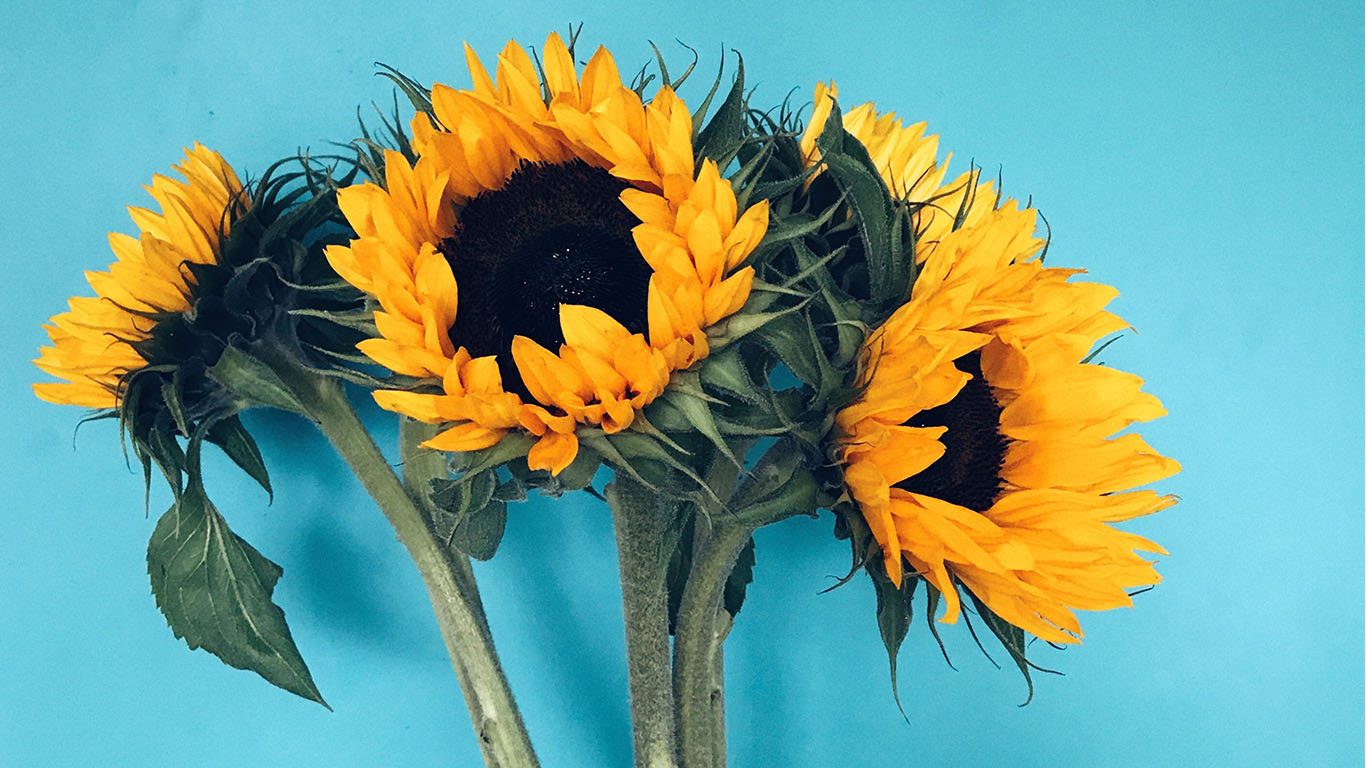

In [7]:
imgs[0]

In [8]:
img_trans = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

lst_th_imgs = [img_trans(x) for x in imgs]
lst_th_imgs[0].shape

torch.Size([3, 224, 398])

In [9]:
th_imgs = th.cat([x.unsqueeze(0) for x in lst_th_imgs])
th_imgs.shape

torch.Size([14, 3, 224, 398])

In [14]:
def th_im_show(th_img):
    np_img = th_img.detach().cpu().numpy().transpose([1,2,0])
    _mean = [0.485, 0.456, 0.406]
    _std = [0.229, 0.224, 0.225]
    np_img = np.clip(np_img * _std + _mean, 0, 1)
    plt.figure()
    plt.imshow(np_img)    

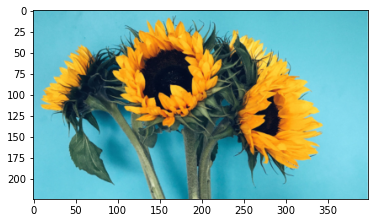

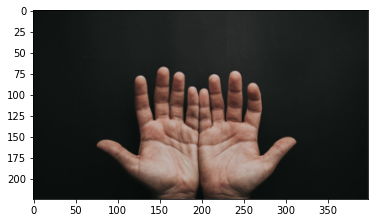

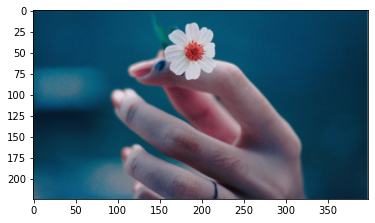

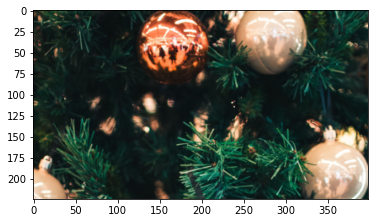

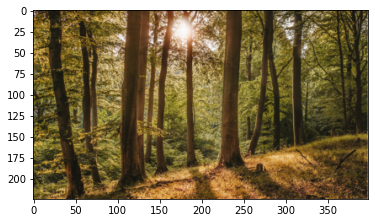

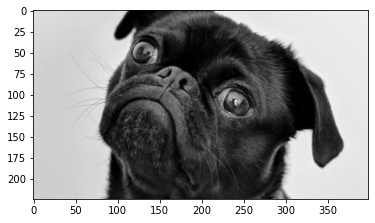

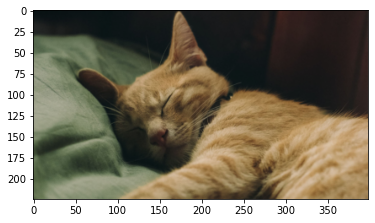

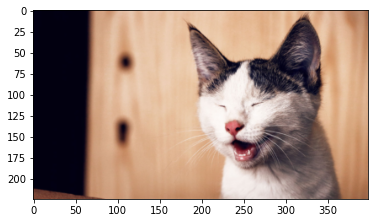

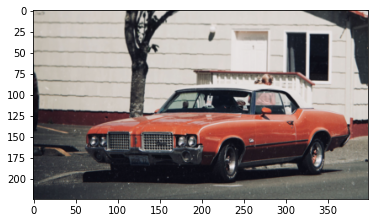

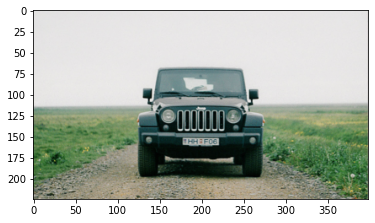

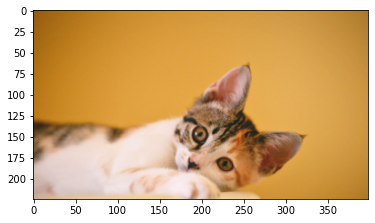

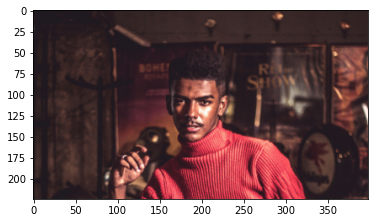

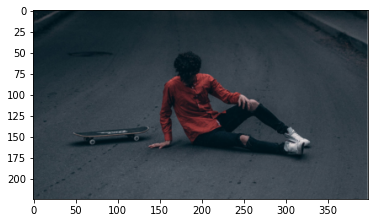

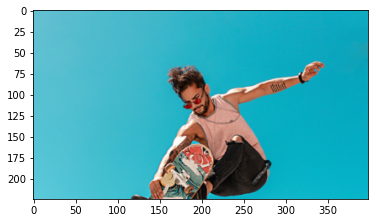

In [15]:
for th_img in th_imgs:
    th_im_show(th_img)

In [19]:
device = th.device('cuda')
th_imgs_gpu = th_imgs.to(device)
th_imgs_gpu.device

device(type='cuda', index=0)

In [20]:
model_alex = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\damia/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth


In [21]:
model_alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [29]:
th.nn.Sequential(
            *list(model_alex.classifier.children())[:-1]
        )

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
)

In [39]:
class Extractor(th.nn.Module):
    def __init__(self, loaded_alex):
        super().__init__()
        self.alex_feats = loaded_alex.features
        self.alex_pool = loaded_alex.avgpool
        self.modified_top = th.nn.Sequential(
            *list(model_alex.classifier.children())[:-1]
        )
        return
    
    def forward(self, th_input):
        th_x = self.alex_feats(th_input)
        th_x = self.alex_pool(th_x)
        th_x = th.flatten(th_x, 1)
        th_x = self.modified_top(th_x)
        return th_x
model = Extractor(loaded_alex=model_alex)    
model = model.to(device)
model

Extractor(
  (alex_feats): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (alex_pool): AdaptiveAvgPool2d(output_size=(6, 6))
  (modified_top): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias

In [40]:
th_emebds_gpu = model(th_imgs_gpu)

In [42]:
th_emebds_gpu.shape

torch.Size([14, 4096])

In [44]:
np_embeds = th_emebds_gpu.detach().cpu().numpy()
np_embeds.shape

(14, 4096)

In [46]:
from sklearn.manifold import TSNE

tsne = TSNE()
tsne.fit(np_emebds)

TSNE()

In [47]:
xy = tsne.embedding_

In [48]:
xy

array([[-306.9921  ,  343.07648 ],
       [  36.118267,  261.46738 ],
       [ 331.75827 ,  392.52234 ],
       [-107.00677 , -530.254   ],
       [ 130.06105 , -215.4075  ],
       [ 534.2411  ,  114.61573 ],
       [-462.38965 ,   43.55549 ],
       [ 224.82167 ,   45.782776],
       [-440.7038  , -296.10648 ],
       [ -14.29967 ,  560.6866  ],
       [-136.51648 ,   46.975903],
       [ 248.70972 , -504.91156 ],
       [-151.19688 , -225.57352 ],
       [ 465.406   , -222.70457 ]], dtype=float32)

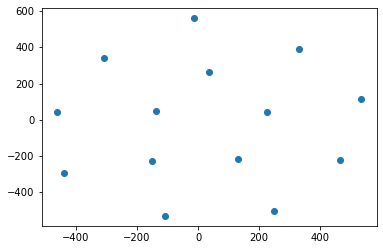

In [50]:
plt.figure()
plt.scatter(xy[:, 0], xy[:, 1])
plt.show()

## TODO:

 1. Add small image to each dot in TSNE so that you can visualy inspect the results
 2. Add more images (100+) & re-run embeddings and visual experiment
 3. Apply k-means or dbscan on the multi-dimensional space (maybe before apply a PCA) with fixed number of cluster
 4. Visualize clusters based on prev point
 5. Determine optimal number of image categories - use k-means elbow algorithm
 6. Re-rewrite the pipeline to use pytorch dataset and data-loaders
 7. **TRY more powerfull models!**
 
#### You can use this homework to prepare a fully functional website that allows users to upload images and generates automated categories further allowing searches/browsing.